In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import os.path
import random
import numpy as np

import torch.utils.data as data
from PIL import Image

def default_loader(filepath):
    return Image.open(filepath).convert('RGB')

class Reader(data.Dataset):
    def __init__(self, image_list, labels_list=[], edge_list=[], transform=None, target_transform=None, use_cache=True, loader=default_loader):
        
        self.images = image_list
        self.loader = loader
        
        if len(labels_list) is not 0:
            assert len(image_list) == len(labels_list)
            self.labels = labels_list
            self.edges = edge_list
        else:
            self.labels = False
            self.edges = False

        self.transform = transform
        self.target_transform = target_transform

        self.cache = {}
        self.use_cache = use_cache

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx not in self.cache:           
            img = self.loader(self.images[idx])
            if self.labels:
                target = Image.open(self.labels[idx])
                edge = Image.open(self.edges[idx])
            else:
                target = None
        else:
            img,target,edge = self.cache[idx]
            
        if self.use_cache:
            self.cache[idx] = (img, target, edge)

        seed = np.random.randint(2147483647)
        random.seed(seed)
        
        if self.transform is not None:
            img = self.transform(img)

        random.seed(seed)
        if self.labels:
            if self.target_transform is not None:
                target = self.target_transform(target)

        random.seed(seed)
        if self.edges:
            if self.target_transform is not None:
                edge = self.target_transform(edge)
            
        return np.array(img), np.array(target), np.array(edge)

In [0]:
from os import listdir
from os.path import join

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader 

basepath = 'gdrive/My Drive/Datasets/A1'

rgb = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_label.png')])
edges = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_edge.png')])

if 0 == len(rgb):
    print("No cvppp dataset found in:" + basepath)
    exit(-1)

# Check the names are paired correctly
assert np.array([img[:-7] == lbl[:-9] for img, lbl in zip(rgb, labels)]).all() == True


np.random.seed(1203412412)
indexes = np.random.permutation(len(rgb))
perm_rgb = np.array(rgb)[indexes].tolist()
perm_labels = np.array(labels)[indexes].tolist()


dimx,dimy = 448,448

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomResizedCrop(448,scale=(0.7,1.)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

class ToLogits(object):
    def __init__(self,expand_dim=None):
        self.expand_dim = expand_dim

    def __call__(self, pic):
        if pic.mode == 'I':
            img = torch.from_numpy(numpy.array(pic, numpy.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(numpy.array(pic, numpy.int32, copy=True))
        elif pic.mode == 'F':
            img = torch.from_numpy(numpy.array(pic, numpy.float32, copy=False))
        elif pic.mode == '1':
            img = 255 * torch.from_numpy(numpy.array(pic, numpy.uint8, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if self.expand_dim is not None:
            return img.unsqueeze(self.expand_dim)
        return img

transform_target = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomResizedCrop(448,scale=(0.7,1.),interpolation=0),
     ToLogits()])

In [0]:
def log_weights_norm(gain=1.):
    def f(w):
        w[w < 2] = 2.
        w = gain / torch.log(w)
        return w
    return f

def get_embeddings_fast(numpy_gt, sin_pattern,  weights_norm=None):
    nobj = numpy_gt.max().item()+1
    nsamples, xdim, ydim = numpy_gt.shape
    nemb = sin_pattern.size(0)

    t = sin_pattern.transpose(1, 0).transpose(2, 1).view(1, -1, nemb).repeat(nsamples, 1, 1)

    indexes_raw = numpy_gt.float()
    indexes = numpy_gt.long()
    w = torch.zeros(nsamples, nobj).to(sin_pattern.device)
    w = w.scatter_add(1, indexes.view(nsamples, -1), torch.ones_like(indexes_raw).view(nsamples, -1))
    e = torch.zeros(nsamples, nobj, nemb).to(sin_pattern.device)
    e = e.scatter_add(1, indexes.view(nsamples, -1, 1).repeat(1, 1, nemb), t)
    w[w == 0] = 1.
    e = e / w.unsqueeze(-1)
    if weights_norm is not None:
        w = weights_norm(w)

    w = torch.gather(w, 1, indexes.view(nsamples, -1))
    e = torch.gather(e, 1, indexes.view(nsamples, -1, 1).repeat(1, 1, nemb))
    e = e.transpose(2, 1).contiguous()

    return e.view(nsamples, nemb, xdim, ydim), w.view(nsamples, xdim, ydim)

class EmbedderFast:
    def __init__(self, sin_pattern, weights_norm=None):
        self.sin_pattern = sin_pattern
        self.weights_norm = weights_norm

    def __call__(self, numpy_gt):
        return get_embeddings_fast(numpy_gt, self.sin_pattern, self.weights_norm)

In [0]:

class GatedConv(nn.Module):
    def __init__(self, in_dims, out_dims, kernel_size=3, padding=1, stride=1, dilation=1):
        super(GatedConv, self).__init__()
        self.f = nn.Conv2d(in_dims, out_dims, kernel_size=kernel_size, padding=padding, stride=stride,
                           dilation=dilation)
        self.g = nn.Conv2d(in_dims, out_dims, kernel_size=kernel_size, padding=padding, stride=stride,
                           dilation=dilation)

    def forward(self, x):
        mask = torch.sigmoid(self.g(x))
        return self.f(x) * mask

class GuidedConv(nn.Module):
  def __init__(self, guides, downscale, in_channels, out_channels, kernel_size, stride=1, padding=0,conv_op= nn.Conv1d):
    super(GuidedConv,self).__init__()
    self.guides = nn.functional.interpolate(guides.clone().detach().unsqueeze(0),scale_factor=1./downscale,mode='bilinear')
    self.guides.requires_grad_(False)
    self.conv = nn.Conv2d(in_channels+self.guides.size(1),out_channels,kernel_size,stride,padding)
  def forward(self,x):
    joimnt = torch.cat([x,self.guides.repeat(x.size(0),1,1,1)],dim=1)
    return self.conv(joimnt)

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch,conv_op=nn.Conv2d):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            conv_op(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            conv_op(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch,conv_op=nn.Conv2d):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch,conv_op)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class ups(nn.Module):
    def __init__(self, in_ch, out_ch, guides, downscale=1,conv_op=nn.Conv2d):
        super(ups, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.sinconv = GuidedConv(guides, downscale, in_channels=in_ch, out_channels=out_ch, kernel_size=7, padding=3,conv_op=conv_op)
        self.conv = double_conv(out_ch, out_ch,conv_op)

    def forward(self, x1, x2):
        x1 = self.up(x1)
      
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.sinconv(x)
        x = self.conv(x)
        return x

class out_mod(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch,conv_op=nn.Conv2d):
      super(out_mod, self).__init__()
      self.outc = double_conv(in_ch, in_ch,conv_op)
      self.attention = nn.Sequential(conv_op(in_ch,out_ch,3,1,1),
                                     nn.Sigmoid())
      self.outc2 =conv_op(in_ch,out_ch,3,1,1)
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, xr, y=None):
      x = self.outc2(self.outc(xr))
      if y is not None:
        att = self.attention(xr)
        x = att*x + (1.-att)*self.up(y)
      return x

class UNet(nn.Module):
    def __init__(self, n_channels, guides, conv_op=nn.Conv2d):
        super(UNet, self).__init__()
        guides = guides.detach()
        guides.requires_grad_(False)
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128,conv_op)
        self.down2 = down(128, 256,conv_op)
        self.down3 = down(256, 512,conv_op)
        self.down4 = down(512, 512,conv_op)
        self.up1 = ups(1024, 256,guides,8,conv_op)
        self.up2 = ups(512, 128,guides,4,conv_op)
        self.up3 = ups(256, 64,guides,2,conv_op)
        self.up4 = ups(128, 64,guides,1,conv_op)
        self.outc4 = out_mod(64, guides.size(0),conv_op)
        self.outc3 = out_mod(64, guides.size(0),conv_op)
        self.outc2 = out_mod(128, guides.size(0),conv_op)
        self.outc1 = out_mod(256, guides.size(0),conv_op)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        y = self.outc1(x)
        x = self.up2(x, x3)
        y = self.outc2(x,y)
        x = self.up3(x, x2)
        y = self.outc3(x,y)
        x = self.up4(x, x1)
        return self.outc4(x,y)


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sins = [[-24.22295570373535, 0.0, 0.4452361464500427],
 [-14.779047012329102, 0.0, 1.2561423778533936],
 [-16.399198532104492, 0.0, -0.3734317719936371],
 [18.362571716308594, 0.0, 0.7659217715263367],
 [-0.6603534817695618, 0.0, 0.24005144834518433],
 [-33.7341423034668, 0.0, -0.4350433051586151],
 [0.0, 4.286965370178223, 0.8109257817268372],
 [0.0, -19.908288955688477, 0.614355206489563],
 [0.0, 22.987812042236328, 0.28104516863822937],
 [0.0, 7.108828067779541, 0.4827950894832611],
 [0.0, 23.66850471496582, 0.21264752745628357],
 [0.0, -22.332250595092773, 1.0007625818252563]]

def create_guide_function(alpha,beta,phase,x_dim,y_dim):
    alpha = torch.FloatTensor(alpha).unsqueeze(-1).unsqueeze(-1)
    beta = torch.FloatTensor(beta).unsqueeze(-1).unsqueeze(-1)
    phase= torch.FloatTensor(phase).unsqueeze(-1).unsqueeze(-1)

    xx_channel = torch.linspace(0.,1.,x_dim).repeat(1, y_dim, 1).float()
    yy_channel = torch.linspace(0.,1.,y_dim).repeat(1, x_dim, 1).transpose(1, 2).float()

    xx_channel = xx_channel * alpha
    yy_channel = yy_channel * beta
    return torch.sin(xx_channel+ yy_channel+phase)

sins = np.array(sins)
guides = create_guide_function(sins[:,0],sins[:,1],sins[:,2],448,448)
#unet = UNet(3,guides.to(device),conv_op=GatedConv).to(device)

In [8]:
unet = UNet(3,guides.to(device),conv_op=GatedConv).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [9]:
pytorch_total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
pytorch_total_params

43056896

In [0]:

errors = []

train_data = Reader(rgb, labels,edges, transform, transform_target)
generator = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=8)

unet = UNet(3,guides.to(device),conv_op=GatedConv).to(device)
optim = torch.optim.Adam(unet.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

caption = join(basepath,"cvppp")
if os.path.exists(caption + '_ckp.t7'):
  data = torch.load(caption + '_ckp.t7')
  unet.load_state_dict(data['model_state_dict'])
  optim.load_state_dict(data['optimizer_state_dict'])

for e in range(1000):
  for x,y,z in generator:
    optim.zero_grad()
    y_grad, weight =embedder(y.squeeze().to(device))
    y_pred =unet(x.to(device))
    z = z.to(device).float()
    loss = torch.nn.functional.l1_loss(y_pred,y_grad, reduce=False)
    edge_loss = torch.mean(torch.mean(loss, dim=1)*z)
    loss = torch.mean((weight.detach() * torch.mean(loss, dim=1)))+10.*edge_loss
    loss.backward()
    errors+=[loss.item()]
    optim.step()
      
  print(np.log(loss.item()))
  torch.save({
          'epoch': e,
          'model_state_dict': unet.state_dict(),
          'optimizer_state_dict': optim.state_dict(),
          'loss': loss
      }, caption + '_ckp2.t7')

plt.plot(errors)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


-3.0772068128236256
-3.30778925174196
-3.322792634465032
-3.1103595378177067
-3.350639901587841
-3.3983712609650274
-3.4328501326381233
-3.7157681209100084
-3.0467209373616626
-3.2642913833646623
-3.404698369165618
-3.3008044908961596
-3.272861353445249
-3.412518741447254
-3.49937355171241
-3.203802388405149
-3.3935209937684627
-3.2802528124338215
-3.037588251375406
-3.200714091279856
-3.2238353106802444
-3.2422778791475753
-3.8019818342727403
-3.372278845931967
-3.1857712508548883
-3.495802627438529
-3.3533812654762856
-3.365953231805793
-3.378664505734049
-3.4280425002263537
-3.5792947362013194
-3.22616911625037
-3.046954057473092
-3.1126639623133605
-3.1893300239019786
-3.3632595433929637
-3.794684994274143
-3.4756859296692526
-3.5061860806559775
-3.1095692533802657
-3.2172399209545373
-3.21897112606034
-3.3436974207609667
-2.896869208064237
-3.454023545358546
-3.248484021022349
-3.2659563035457975
-3.3298917102233325
-3.469856265873294
-3.2304441505518953
-3.5030581182611353
-3.570

NameError: ignored

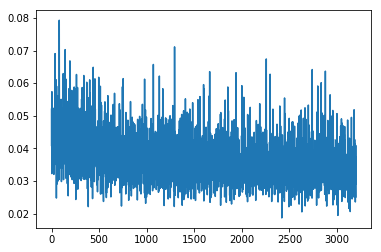

In [0]:
import matplotlib.pyplot as plt
plt.plot(errors)

In [0]:
caption = join(basepath,"cvppp")
data = torch.load(caption + '_ckp.t7')
unet.load_state_dict(data['model_state_dict'],strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
train_data = Reader(rgb, labels, transform, transform_target)

In [0]:
x,y,z = train_data[2]
xx = unet(torch.from_numpy(x).unsqueeze(0).to(device))
print(x.shape)

(3, 448, 448)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


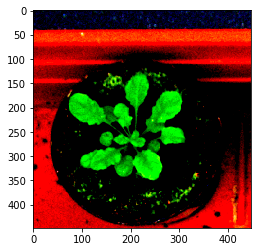

In [0]:
plt.imshow(x.transpose(1,2,0))

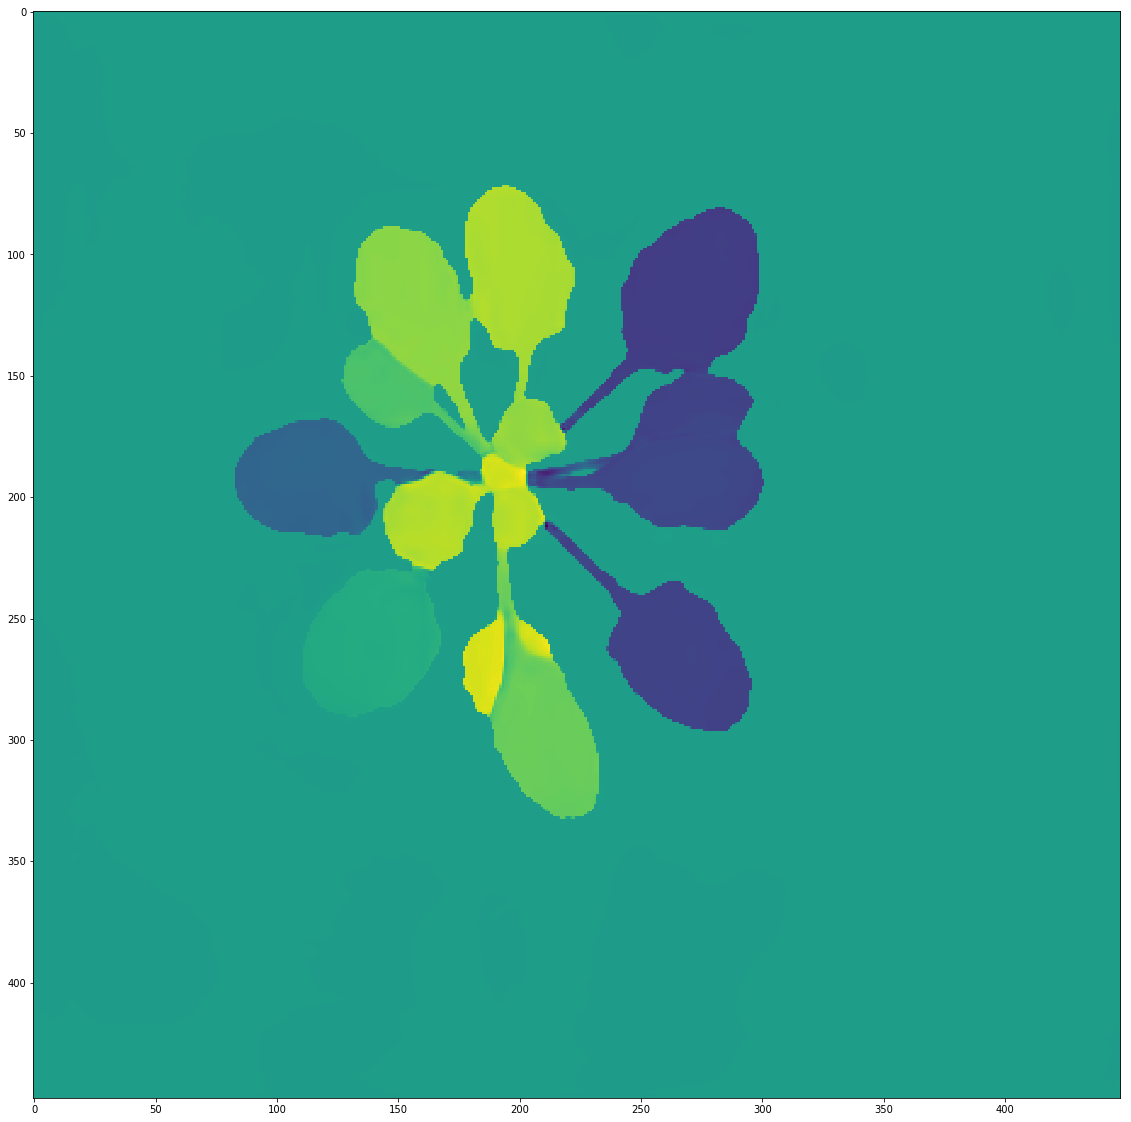

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xx.detach().cpu()[0,1])

In [0]:
def count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count(unet)

43056896

In [0]:
import matplotlib.pyplot as plt
plt.plot(errors)

NameError: ignored

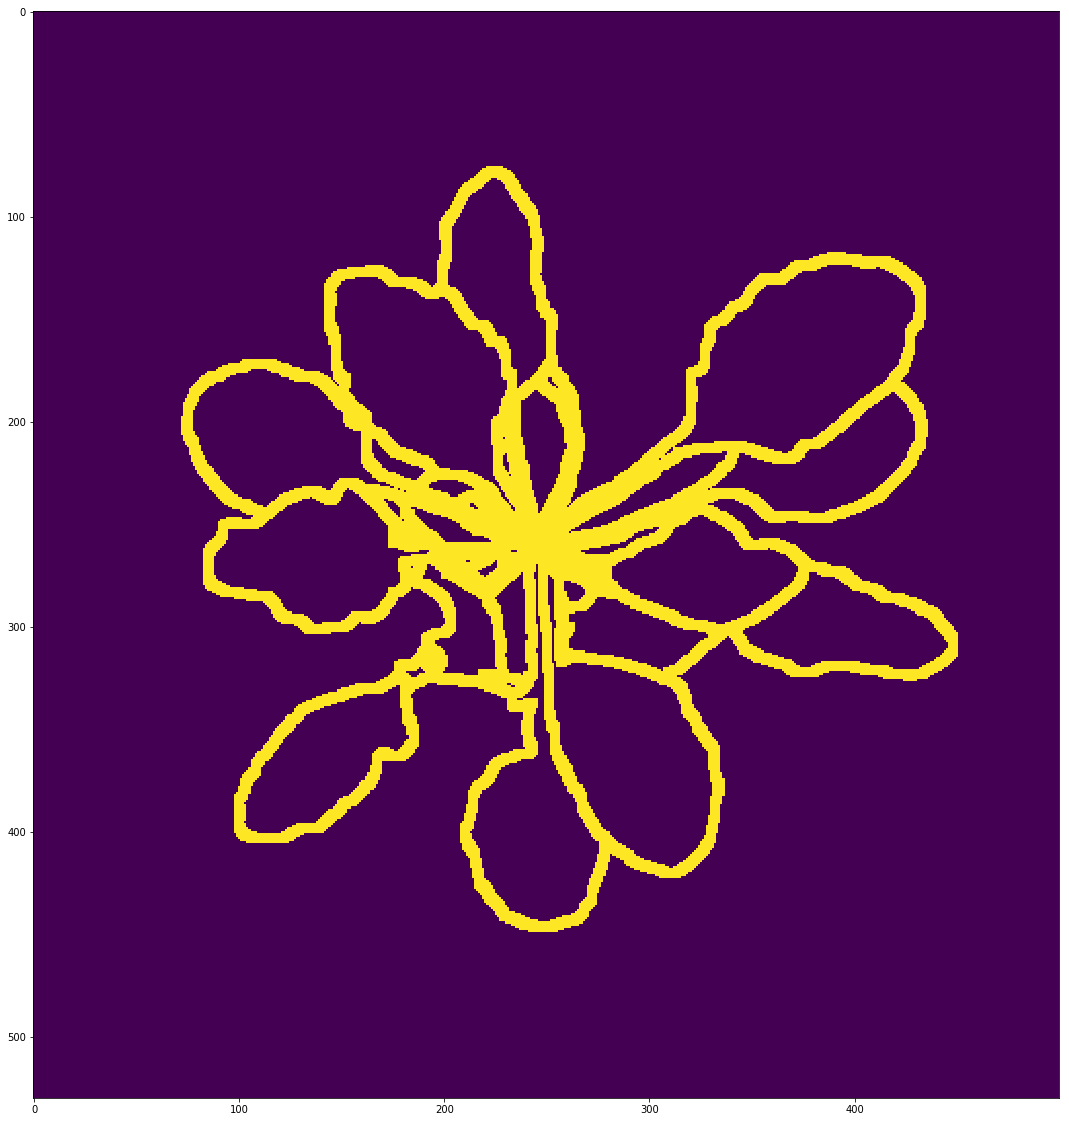

In [0]:
import matplotlib.pyplot as plt
import cv2

for l in labels:
  num_array = np.array(Image.open(l)).astype(np.float32)
  nap = np.zeros_like(num_array)
  dIdx = abs(num_array[:-1,:]-num_array[1: ,:])>0
  dIdy = abs(num_array[:,:-1]-num_array[: ,1:])>0
  nap[1:]+=dIdx
  nap[:,1:]+=dIdy
  nap = np.clip(nap,0,1)
  nap = cv2.dilate(nap,np.ones((5,5))).astype('uint8')
  pil = Image.fromarray(nap)
  pil.save(l[:-9]+"edge.png","PNG")